In [1]:
import numpy as np
import sqlite3
import pandas as pd
import requests
from astropy.io import fits
import astropy
from astropy.table import Table

import matplotlib.pyplot as plt

import string #call eng alphabet


###### ML #######
from sklearn.model_selection import train_test_split #!pip3 install scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error

# 1. Data preparing

## 1.1. Download Data Bases

### 1.1.1. Full Data Base

#### Download the SQLite file from the GRBweb webpage

r = requests.get("https://icecube.wisc.edu/~grbweb_public/GRBweb2.sqlite")
f = open('GRBweb2.sqlite', 'wb').write(r.content)

#### Load the database with the sqlite3 module

db = sqlite3.connect('GRBweb2.sqlite')

#### Print the names of all the tables
From the list of table names, select the one you wish to load.From the list of table names, select the one you wish to load.

table_names = pd.read_sql_query("SELECT * from sqlite_sequence", db)
print("Table names:\n", table_names, "\n\n")

### 1.1.2. Swift table

swift_table = pd.read_sql_query("SELECT * from Swift", db)
swift_table = swift_table.sort_values("GRB_name").reset_index().drop("index",axis=1)
swift_table

swift_table.info()

### 1.1.3. Fermi table

fermi_table = pd.read_sql_query("SELECT * from Fermi_GBM", db)
fermi_table = fermi_table.sort_values('GRB_name_Fermi').reset_index().drop("index",axis=1)
fermi_table

fermi_table.info()

### 1.1.3. Summary table

summary_table = pd.read_sql_query("SELECT * from Summary", db)

summary_table.to_csv("summary_table_grb.csv")

summary_table.info()

## 1.2. Data reduction (using online tables, save them and one local unite table)

* Preparing to cross matching -- create new names (Fermi style -> Swift style)
* Cross matching (Fermi-Swift)
* Creating new larger table 

### 1.2.1. Preparing to cross matching

alphabet = list(string.ascii_uppercase)
dictionary = {}
for i in range(0,len(fermi_table)):
    #print(i)
    grb_one_date = []
    for j in range(0,len(fermi_table)):
        if fermi_table['GRB_name_Fermi'].iloc[i][:9] == fermi_table['GRB_name_Fermi'].iloc[j][:9]:
            grb_one_date.append(fermi_table['GRB_name_Fermi'].iloc[j])
    
    grb_one_date.sort()
    #print(grb_one_date)

    for n in range(0,len(grb_one_date)):
        dictionary[grb_one_date[n]] = grb_one_date[n][:9] + alphabet[n]
    #print(dictionary)
    #print("_____________________________")



### 1.2.2. Cross match

fermi_table['GRB_name_Swift'] = ""*len(fermi_table)
for i in range(0,len(fermi_table)):
    fermi_table['GRB_name_Swift'].iloc[i] = dictionary[fermi_table['GRB_name_Fermi'].iloc[i]]

fermi_table

### 1.2.3. Creating new table

sf_table = swift_table #make copy of Swift table to add here 
# additional tables from Fermi catalogue (cross matching)

sf_table

sf_table["GRB_name_Swift"] = sf_table["GRB_name"]

sf_table = sf_table.merge(fermi_table, how="left", on="GRB_name_Swift", suffixes=('_swift', '_fermi'))
sf_table

fermi_table.to_csv("grb_fermi_catalogue")
swift_table.to_csv("grb_swift_catalogue")
sf_table.to_csv("grb_swift_fermi_catalogue_for_ml")

## 1.3. Data reduction (using local summary table)

In [2]:
data = pd.read_csv("summary_table_grb.csv")

In [3]:
#we have to edit name of GRBs because somewhere may be spaces 
#and if somewhere the is lower case we have to fix it on upper case
for ind,name in enumerate(data["GRB_name_Fermi"]):
    data["GRB_name_Fermi"].iloc[ind] = str(name).upper().strip()

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_95053/3069133779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["GRB_name_Fermi"].iloc[ind] = str(name).upper().strip()


In [5]:
#to use data in Fermi catalogue we have to drop rows with no Ferni name of GRBs

data_nonull = data[data["GRB_name_Fermi"].notnull()]

#because then we will set names of GRBs as indexes and there should not be NULL value
#there will not be an error, but it is better to protect it from possible errors

data_redshift=data_nonull[["GRB_name_Fermi","redshift"]].set_index("GRB_name_Fermi")

## 1.4. Data reduction (Fermi table)

In [6]:
fermi_astrotable = Table(fits.open("fermi_full_2022.fits")[1].data)
fermi_full = fermi_astrotable.to_pandas()

In [7]:
fermi_full = fermi_full.rename(columns={"NAME":"GRB_name_Fermi"})#we rename the column because
#it another table (data_redshift -- summary table from icecube) it is named in this way

#we have to edit name of GRBs because somewhere may be spaces 
#and if somewhere the is lower case we have to fix it on upper case
for ind,name in enumerate(fermi_full["GRB_name_Fermi"]):
    fermi_full["GRB_name_Fermi"].iloc[ind] = str(name).upper().strip()

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_95053/2132666068.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_full["GRB_name_Fermi"].iloc[ind] = str(name).upper().strip()


In [8]:
#we join two tables with known redshifts and another data on events

fermi_rs = fermi_full.join(data_redshift,how="left",on="GRB_name_Fermi")

#and remove GRBs without known redshift

fermi_rs = fermi_rs[fermi_rs["redshift"].notnull()].reset_index().drop("index",axis=1)
fermi_rs = fermi_rs[fermi_rs["FLNC_BAND_AMPL"]!=0].reset_index().drop("index",axis=1)

In [9]:
drop_indexes_comp = []
drop_indexes_band = []
for ind,mod in enumerate(fermi_rs["FLNC_BEST_FITTING_MODEL"]):
    if str(fermi_rs["FLNC_BEST_FITTING_MODEL"].iloc[ind]).lower().strip()=="flnc_comp":   
        continue
    else:
        drop_indexes_comp.append(ind)
        
for ind,mod in enumerate(fermi_rs["FLNC_BEST_FITTING_MODEL"]):
    if str(fermi_rs["FLNC_BEST_FITTING_MODEL"].iloc[ind]).lower().strip()=="flnc_band":
        continue
    else:
        drop_indexes_band.append(ind)

fermi_rs_comp = fermi_rs.drop(drop_indexes_comp,axis=0).reset_index().drop("index",axis=1)
print("fermi_rs_comp: ",len(fermi_rs_comp))
fermi_rs_band = fermi_rs.drop(drop_indexes_band,axis=0).reset_index().drop("index",axis=1)
print("fermi_rs_band: ",len(fermi_rs_band))

fermi_rs_comp:  77
fermi_rs_band:  27


In [10]:
#now we schould remove unnecessary for ml columns 
#we suggest that GRBs have isotropic distribution, so we do not need columns with coordinates
#also we do not need columns with estimated errors
#names are irrelevant
#we do not need string data
#
fermi_rs = fermi_rs[[
                     'T90',
                     'FLUENCE',
                     'FLUX_1024',
                     'FLUX_1024_TIME',
                     'FLUX_64',
                     
                     'FLNC_BAND_AMPL',
                     'FLNC_BAND_EPEAK',
                     'FLNC_BAND_ALPHA',
                     'FLNC_BAND_BETA',
                     'FLNC_SPECTRUM_START',
                     'FLNC_SPECTRUM_STOP',
                     
                     'LII',
                     'BII',
                     'DURATION_ENERGY_LOW',
                     'DURATION_ENERGY_HIGH',
                     'BACK_INTERVAL_LOW_START',
                     'BACK_INTERVAL_LOW_STOP',
                     'BACK_INTERVAL_HIGH_START',
                     'BACK_INTERVAL_HIGH_STOP',
                     'T50',
                     'FLU_LOW',
                     'FLU_HIGH',
                     
                     'FLUENCE_BATSE',
                    
                     'FLUX_64_TIME',
                     'FLUX_256',
                     'FLUX_256_TIME',
                     'FLUX_BATSE_1024',
                     'FLUX_BATSE_1024_TIME',
                     'FLUX_BATSE_64',
                     'FLUX_BATSE_64_TIME',
                     'FLUX_BATSE_256',
                     'FLUX_BATSE_256_TIME',
                     
                     'ACTUAL_64MS_INTERVAL',
                     'ACTUAL_256MS_INTERVAL',
                     'ACTUAL_1024MS_INTERVAL',
    
                     'PFLX_SPECTRUM_START',
                     'PFLX_SPECTRUM_STOP',
                     'PFLX_PLAW_AMPL',
                     'PFLX_PLAW_PIVOT',
                     'PFLX_PLAW_INDEX',
                     'PFLX_PLAW_PHTFLUX',
                     'PFLX_PLAW_PHTFLNC',
                     'PFLX_PLAW_ERGFLUX',
                     'PFLX_PLAW_ERGFLNC',
                     'PFLX_PLAW_PHTFLUXB',
                     'PFLX_PLAW_PHTFLNCB',
                     'PFLX_PLAW_ERGFLNCB',
                     'PFLX_PLAW_REDCHISQ',
                     'PFLX_PLAW_REDFITSTAT',
                     'PFLX_PLAW_DOF',
                     
                     'PFLX_COMP_AMPL',
                     'PFLX_COMP_EPEAK',
                     'PFLX_COMP_INDEX',
                     'PFLX_COMP_PIVOT',
                     'PFLX_COMP_PHTFLUX',
                     'PFLX_COMP_PHTFLNC',
                     'PFLX_COMP_ERGFLUX',
                     'PFLX_COMP_ERGFLNC',
                     'PFLX_COMP_PHTFLUXB',
                     'PFLX_COMP_PHTFLNCB',
                     'PFLX_COMP_ERGFLNCB',
                     'PFLX_COMP_REDCHISQ',
                     'PFLX_COMP_REDFITSTAT',
                     'PFLX_COMP_DOF',
                     
                     'PFLX_BAND_AMPL',
                     'PFLX_BAND_EPEAK',
                     'PFLX_BAND_ALPHA',
                     'PFLX_BAND_BETA',
                     'PFLX_BAND_PHTFLUX',
                     'PFLX_BAND_PHTFLNC',
                     'PFLX_BAND_ERGFLUX',
                     'PFLX_BAND_ERGFLNC',
                     'PFLX_BAND_PHTFLUXB',
                     'PFLX_BAND_PHTFLNCB',
                     'PFLX_BAND_ERGFLNCB',
                     'PFLX_BAND_REDCHISQ',
                     'PFLX_BAND_REDFITSTAT',
                     'PFLX_BAND_DOF',
                     
                     'PFLX_SBPL_AMPL',
                     'PFLX_SBPL_PIVOT',
                     'PFLX_SBPL_INDX1',
                     'PFLX_SBPL_BRKEN',
                     'PFLX_SBPL_BRKSC',
                     'PFLX_SBPL_INDX2',
                     'PFLX_SBPL_PHTFLUX',
                     'PFLX_SBPL_PHTFLNC',
                     'PFLX_SBPL_ERGFLUX',
                     'PFLX_SBPL_ERGFLNC',
                     'PFLX_SBPL_PHTFLUXB',
                     'PFLX_SBPL_PHTFLNCB',
                     'PFLX_SBPL_ERGFLNCB',
                     'PFLX_SBPL_REDCHISQ',
                     'PFLX_SBPL_REDFITSTAT',
                     'PFLX_SBPL_DOF',
                     
                     'FLNC_COMP_AMPL',
                     'FLNC_COMP_EPEAK',
                     'FLNC_COMP_INDEX',
                     'FLNC_COMP_PIVOT',
                     'FLNC_COMP_PHTFLUX',
                     'FLNC_COMP_PHTFLNC',
                     'FLNC_COMP_ERGFLUX',
                     'FLNC_COMP_ERGFLNC',
                     'FLNC_COMP_PHTFLUXB',
                     'FLNC_COMP_PHTFLNCB',
                     'FLNC_COMP_ERGFLNCB',
                     'FLNC_COMP_REDCHISQ',
                     'FLNC_COMP_REDFITSTAT',
                     'FLNC_COMP_DOF',
                     
                     'FLNC_BAND_PHTFLUX',
                     'FLNC_BAND_PHTFLNC',
                     'FLNC_BAND_ERGFLUX',
                     'FLNC_BAND_ERGFLNC',
                     'FLNC_BAND_PHTFLUXB',
                     'FLNC_BAND_PHTFLNCB',
                     'FLNC_BAND_ERGFLNCB',
                     'FLNC_BAND_REDCHISQ',
                     'FLNC_BAND_REDFITSTAT',
                     'FLNC_BAND_DOF',
                     
                     'FLNC_SBPL_AMPL',
                     'FLNC_SBPL_AMPL_POS_ERR',
                     'FLNC_SBPL_PIVOT',
                     'FLNC_SBPL_INDX1',
                     'FLNC_SBPL_BRKEN',
                     'FLNC_SBPL_BRKSC',
                     'FLNC_SBPL_INDX2',
                     'FLNC_SBPL_PHTFLUX', 
                     'FLNC_SBPL_PHTFLNC',
                     'FLNC_SBPL_ERGFLUX', 
                     'FLNC_SBPL_ERGFLNC', 
                     'FLNC_SBPL_PHTFLUXB',
                     'FLNC_SBPL_PHTFLNCB',
                     'FLNC_SBPL_ERGFLNCB',
                     'FLNC_SBPL_REDCHISQ',
                     'FLNC_SBPL_REDFITSTAT',
                     'FLNC_SBPL_DOF',
                     'redshift']]

In [12]:
#now we schould remove unnecessary for ml columns 
#we suggest that GRBs have isotropic distribution, so we do not need columns with coordinates
#also we do not need columns with estimated errors
#names are irrelevant
#we do not need string data
#
fermi_band_comp = fermi_rs[[
                     'T90',
                     'FLUENCE',
                     'FLUX_1024',
                     'FLUX_1024_TIME',
                     'FLUX_64',
                     
                     'FLNC_BAND_AMPL',
                     'FLNC_BAND_EPEAK',
                     'FLNC_BAND_ALPHA',
                     'FLNC_BAND_BETA',
                     'FLNC_SPECTRUM_START',
                     'FLNC_SPECTRUM_STOP',
                     
                     'LII',
                     'BII',
                     'DURATION_ENERGY_LOW',
                     'DURATION_ENERGY_HIGH',
                     'BACK_INTERVAL_LOW_START',
                     'BACK_INTERVAL_LOW_STOP',
                     'BACK_INTERVAL_HIGH_START',
                     'BACK_INTERVAL_HIGH_STOP',
                     'T50',
                     'FLU_LOW',
                     'FLU_HIGH',
                     
                     'FLUENCE_BATSE',
                    
                     'FLUX_64_TIME',
                     'FLUX_256',
                     'FLUX_256_TIME',
                     'FLUX_BATSE_1024',
                     'FLUX_BATSE_1024_TIME',
                     'FLUX_BATSE_64',
                     'FLUX_BATSE_64_TIME',
                     'FLUX_BATSE_256',
                     'FLUX_BATSE_256_TIME',
                     
                     'ACTUAL_64MS_INTERVAL',
                     'ACTUAL_256MS_INTERVAL',
                     'ACTUAL_1024MS_INTERVAL',
    
                     'PFLX_SPECTRUM_START',
                     'PFLX_SPECTRUM_STOP',
                     
                     'PFLX_COMP_AMPL',
                     'PFLX_COMP_EPEAK',
                     'PFLX_COMP_INDEX',
                     'PFLX_COMP_PIVOT',
                     'PFLX_COMP_PHTFLUX',
                     'PFLX_COMP_PHTFLNC',
                     'PFLX_COMP_ERGFLUX',
                     'PFLX_COMP_ERGFLNC',
                     'PFLX_COMP_PHTFLUXB',
                     'PFLX_COMP_PHTFLNCB',
                     'PFLX_COMP_ERGFLNCB',
                     'PFLX_COMP_REDCHISQ',
                     'PFLX_COMP_REDFITSTAT',
                     'PFLX_COMP_DOF',
                     
                     'PFLX_BAND_AMPL',
                     'PFLX_BAND_EPEAK',
                     'PFLX_BAND_ALPHA',
                     'PFLX_BAND_BETA',
                     'PFLX_BAND_PHTFLUX',
                     'PFLX_BAND_PHTFLNC',
                     'PFLX_BAND_ERGFLUX',
                     'PFLX_BAND_ERGFLNC',
                     'PFLX_BAND_PHTFLUXB',
                     'PFLX_BAND_PHTFLNCB',
                     'PFLX_BAND_ERGFLNCB',
                     'PFLX_BAND_REDCHISQ',
                     'PFLX_BAND_REDFITSTAT',
                     'PFLX_BAND_DOF',
                     
                     'FLNC_COMP_AMPL',
                     'FLNC_COMP_EPEAK',
                     'FLNC_COMP_INDEX',
                     'FLNC_COMP_PIVOT',
                     'FLNC_COMP_PHTFLUX',
                     'FLNC_COMP_PHTFLNC',
                     'FLNC_COMP_ERGFLUX',
                     'FLNC_COMP_ERGFLNC',
                     'FLNC_COMP_PHTFLUXB',
                     'FLNC_COMP_PHTFLNCB',
                     'FLNC_COMP_ERGFLNCB',
                     'FLNC_COMP_REDCHISQ',
                     'FLNC_COMP_REDFITSTAT',
                     'FLNC_COMP_DOF',
                     
                     'FLNC_BAND_PHTFLUX',
                     'FLNC_BAND_PHTFLNC',
                     'FLNC_BAND_ERGFLUX',
                     'FLNC_BAND_ERGFLNC',
                     'FLNC_BAND_PHTFLUXB',
                     'FLNC_BAND_PHTFLNCB',
                     'FLNC_BAND_ERGFLNCB',
                     'FLNC_BAND_REDCHISQ',
                     'FLNC_BAND_REDFITSTAT',
                     'FLNC_BAND_DOF',

                     'redshift']]

In [13]:
#now we schould remove unnecessary for ml columns 
#we suggest that GRBs have isotropic distribution, so we do not need columns with coordinates
#also we do not need columns with estimated errors
#names are irrelevant
#we do not need string data
#
fermi_pflx = fermi_rs[[
                     'T90',
                     'FLUENCE',
                     'FLUX_1024',
                     'FLUX_1024_TIME',
                     'FLUX_64',
                     
                     'LII',
                     'BII',
                     'DURATION_ENERGY_LOW',
                     'DURATION_ENERGY_HIGH',
                     'BACK_INTERVAL_LOW_START',
                     'BACK_INTERVAL_LOW_STOP',
                     'BACK_INTERVAL_HIGH_START',
                     'BACK_INTERVAL_HIGH_STOP',
                     'T50',
                     'FLU_LOW',
                     'FLU_HIGH',
                     
                     'FLUENCE_BATSE',
                    
                     'FLUX_64_TIME',
                     'FLUX_256',
                     'FLUX_256_TIME',
                     'FLUX_BATSE_1024',
                     'FLUX_BATSE_1024_TIME',
                     'FLUX_BATSE_64',
                     'FLUX_BATSE_64_TIME',
                     'FLUX_BATSE_256',
                     'FLUX_BATSE_256_TIME',
                     
                     'ACTUAL_64MS_INTERVAL',
                     'ACTUAL_256MS_INTERVAL',
                     'ACTUAL_1024MS_INTERVAL',
    
                     'PFLX_SPECTRUM_START',
                     'PFLX_SPECTRUM_STOP',
                     'PFLX_PLAW_AMPL',
                     'PFLX_PLAW_PIVOT',
                     'PFLX_PLAW_INDEX',
                     'PFLX_PLAW_PHTFLUX',
                     'PFLX_PLAW_PHTFLNC',
                     'PFLX_PLAW_ERGFLUX',
                     'PFLX_PLAW_ERGFLNC',
                     'PFLX_PLAW_PHTFLUXB',
                     'PFLX_PLAW_PHTFLNCB',
                     'PFLX_PLAW_ERGFLNCB',
                     'PFLX_PLAW_REDCHISQ',
                     'PFLX_PLAW_REDFITSTAT',
                     'PFLX_PLAW_DOF',
                     
                     'PFLX_COMP_AMPL',
                     'PFLX_COMP_EPEAK',
                     'PFLX_COMP_INDEX',
                     'PFLX_COMP_PIVOT',
                     'PFLX_COMP_PHTFLUX',
                     'PFLX_COMP_PHTFLNC',
                     'PFLX_COMP_ERGFLUX',
                     'PFLX_COMP_ERGFLNC',
                     'PFLX_COMP_PHTFLUXB',
                     'PFLX_COMP_PHTFLNCB',
                     'PFLX_COMP_ERGFLNCB',
                     'PFLX_COMP_REDCHISQ',
                     'PFLX_COMP_REDFITSTAT',
                     'PFLX_COMP_DOF',
                     
                     'PFLX_BAND_AMPL',
                     'PFLX_BAND_EPEAK',
                     'PFLX_BAND_ALPHA',
                     'PFLX_BAND_BETA',
                     'PFLX_BAND_PHTFLUX',
                     'PFLX_BAND_PHTFLNC',
                     'PFLX_BAND_ERGFLUX',
                     'PFLX_BAND_ERGFLNC',
                     'PFLX_BAND_PHTFLUXB',
                     'PFLX_BAND_PHTFLNCB',
                     'PFLX_BAND_ERGFLNCB',
                     'PFLX_BAND_REDCHISQ',
                     'PFLX_BAND_REDFITSTAT',
                     'PFLX_BAND_DOF',
                     
                     'PFLX_SBPL_AMPL',
                     'PFLX_SBPL_PIVOT',
                     'PFLX_SBPL_INDX1',
                     'PFLX_SBPL_BRKEN',
                     'PFLX_SBPL_BRKSC',
                     'PFLX_SBPL_INDX2',
                     'PFLX_SBPL_PHTFLUX',
                     'PFLX_SBPL_PHTFLNC',
                     'PFLX_SBPL_ERGFLUX',
                     'PFLX_SBPL_ERGFLNC',
                     'PFLX_SBPL_PHTFLUXB',
                     'PFLX_SBPL_PHTFLNCB',
                     'PFLX_SBPL_ERGFLNCB',
                     'PFLX_SBPL_REDCHISQ',
                     'PFLX_SBPL_REDFITSTAT',
                     'PFLX_SBPL_DOF',
                    
                     'redshift']]

In [14]:
#now we schould remove unnecessary for ml columns 
#we suggest that GRBs have isotropic distribution, so we do not need columns with coordinates
#also we do not need columns with estimated errors
#names are irrelevant
#we do not need string data
#
fermi_flnc = fermi_rs[[
                     'T90',
                     'FLUENCE',
                     'FLUX_1024',
                     'FLUX_1024_TIME',
                     'FLUX_64',
                     
                     'FLNC_BAND_AMPL',
                     'FLNC_BAND_EPEAK',
                     'FLNC_BAND_ALPHA',
                     'FLNC_BAND_BETA',
                     'FLNC_SPECTRUM_START',
                     'FLNC_SPECTRUM_STOP',
                     
                     'LII',
                     'BII',
                     'DURATION_ENERGY_LOW',
                     'DURATION_ENERGY_HIGH',
                     'BACK_INTERVAL_LOW_START',
                     'BACK_INTERVAL_LOW_STOP',
                     'BACK_INTERVAL_HIGH_START',
                     'BACK_INTERVAL_HIGH_STOP',
                     'T50',
                     'FLU_LOW',
                     'FLU_HIGH',
                     
                     'FLUENCE_BATSE',
                    
                     'FLUX_64_TIME',
                     'FLUX_256',
                     'FLUX_256_TIME',
                     'FLUX_BATSE_1024',
                     'FLUX_BATSE_1024_TIME',
                     'FLUX_BATSE_64',
                     'FLUX_BATSE_64_TIME',
                     'FLUX_BATSE_256',
                     'FLUX_BATSE_256_TIME',
                     
                     'ACTUAL_64MS_INTERVAL',
                     'ACTUAL_256MS_INTERVAL',
                     'ACTUAL_1024MS_INTERVAL',
                     
                     'FLNC_COMP_AMPL',
                     'FLNC_COMP_EPEAK',
                     'FLNC_COMP_INDEX',
                     'FLNC_COMP_PIVOT',
                     'FLNC_COMP_PHTFLUX',
                     'FLNC_COMP_PHTFLNC',
                     'FLNC_COMP_ERGFLUX',
                     'FLNC_COMP_ERGFLNC',
                     'FLNC_COMP_PHTFLUXB',
                     'FLNC_COMP_PHTFLNCB',
                     'FLNC_COMP_ERGFLNCB',
                     'FLNC_COMP_REDCHISQ',
                     'FLNC_COMP_REDFITSTAT',
                     'FLNC_COMP_DOF',
                     
                     'FLNC_BAND_PHTFLUX',
                     'FLNC_BAND_PHTFLNC',
                     'FLNC_BAND_ERGFLUX',
                     'FLNC_BAND_ERGFLNC',
                     'FLNC_BAND_PHTFLUXB',
                     'FLNC_BAND_PHTFLNCB',
                     'FLNC_BAND_ERGFLNCB',
                     'FLNC_BAND_REDCHISQ',
                     'FLNC_BAND_REDFITSTAT',
                     'FLNC_BAND_DOF',
                     
                     'FLNC_SBPL_AMPL',
                     'FLNC_SBPL_AMPL_POS_ERR',
                     'FLNC_SBPL_PIVOT',
                     'FLNC_SBPL_INDX1',
                     'FLNC_SBPL_BRKEN',
                     'FLNC_SBPL_BRKSC',
                     'FLNC_SBPL_INDX2',
                     'FLNC_SBPL_PHTFLUX', 
                     'FLNC_SBPL_PHTFLNC',
                     'FLNC_SBPL_ERGFLUX', 
                     'FLNC_SBPL_ERGFLNC', 
                     'FLNC_SBPL_PHTFLUXB',
                     'FLNC_SBPL_PHTFLNCB',
                     'FLNC_SBPL_ERGFLNCB',
                     'FLNC_SBPL_REDCHISQ',
                     'FLNC_SBPL_REDFITSTAT',
                     'FLNC_SBPL_DOF',
                     'redshift']]

In [15]:
#now we schould remove unnecessary for ml columns 
#we suggest that GRBs have isotropic distribution, so we do not need columns with coordinates
#also we do not need columns with estimated errors
#names are irrelevant
#we do not need string data
#
fermi_rs_band = fermi_rs[[
                     'T90',
                     'FLUENCE',
                     'FLUX_1024',
                     'FLUX_1024_TIME',
                     'FLUX_64',
                     
                     'FLNC_BAND_AMPL',
                     'FLNC_BAND_EPEAK',
                     'FLNC_BAND_ALPHA',
                     'FLNC_BAND_BETA',
                     'FLNC_SPECTRUM_START',
                     'FLNC_SPECTRUM_STOP',
                     
                     'LII',
                     'BII',
                     'DURATION_ENERGY_LOW',
                     'DURATION_ENERGY_HIGH',
                     'BACK_INTERVAL_LOW_START',
                     'BACK_INTERVAL_LOW_STOP',
                     'BACK_INTERVAL_HIGH_START',
                     'BACK_INTERVAL_HIGH_STOP',
                     'T50',
                     'FLU_LOW',
                     'FLU_HIGH',
                     
                     'FLUENCE_BATSE',
                    
                     'FLUX_64_TIME',
                     'FLUX_256',
                     'FLUX_256_TIME',
                     'FLUX_BATSE_1024',
                     'FLUX_BATSE_1024_TIME',
                     'FLUX_BATSE_64',
                     'FLUX_BATSE_64_TIME',
                     'FLUX_BATSE_256',
                     'FLUX_BATSE_256_TIME',
                     
                     'ACTUAL_64MS_INTERVAL',
                     'ACTUAL_256MS_INTERVAL',
                     'ACTUAL_1024MS_INTERVAL',
                     
                     'PFLX_SPECTRUM_START',
                     'PFLX_SPECTRUM_STOP',
                     
                     'PFLX_BAND_AMPL',
                     'PFLX_BAND_EPEAK',
                     'PFLX_BAND_ALPHA',
                     'PFLX_BAND_BETA',
                     'PFLX_BAND_PHTFLUX',
                     'PFLX_BAND_PHTFLNC',
                     'PFLX_BAND_ERGFLUX',
                     'PFLX_BAND_ERGFLNC',
                     'PFLX_BAND_PHTFLUXB',
                     'PFLX_BAND_PHTFLNCB',
                     'PFLX_BAND_ERGFLNCB',
                     'PFLX_BAND_REDCHISQ',
                     'PFLX_BAND_REDFITSTAT',
                     'PFLX_BAND_DOF',
                     
                     'FLNC_BAND_PHTFLUX',
                     'FLNC_BAND_PHTFLNC',
                     'FLNC_BAND_ERGFLUX',
                     'FLNC_BAND_ERGFLNC',
                     'FLNC_BAND_PHTFLUXB',
                     'FLNC_BAND_PHTFLNCB',
                     'FLNC_BAND_ERGFLNCB',
                     'FLNC_BAND_REDCHISQ',
                     'FLNC_BAND_REDFITSTAT',
                     'FLNC_BAND_DOF',
                      'redshift']]

In [16]:
fermi_rs_band.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   T90                       149 non-null    float64
 1   FLUENCE                   149 non-null    float64
 2   FLUX_1024                 149 non-null    float64
 3   FLUX_1024_TIME            149 non-null    float64
 4   FLUX_64                   149 non-null    float64
 5   FLNC_BAND_AMPL            149 non-null    float64
 6   FLNC_BAND_EPEAK           149 non-null    float64
 7   FLNC_BAND_ALPHA           149 non-null    float64
 8   FLNC_BAND_BETA            149 non-null    float64
 9   FLNC_SPECTRUM_START       149 non-null    float64
 10  FLNC_SPECTRUM_STOP        149 non-null    float64
 11  LII                       149 non-null    float64
 12  BII                       149 non-null    float64
 13  DURATION_ENERGY_LOW       149 non-null    float64
 14  DURATION_E

In [18]:
#now we schould remove unnecessary for ml columns 

fermi_rs = fermi_rs[['GRB_name_Fermi','RA','DEC',
                     'T90',
                     'FLUENCE',
                     'FLUX_1024',
                     'FLUX_1024_TIME',
                     'FLUX_64',
                     
                     'FLNC_BAND_AMPL',
                     'FLNC_BAND_EPEAK',
                     'FLNC_BAND_ALPHA',
                     'FLNC_BAND_BETA',
                     'FLNC_SPECTRUM_START',
                     'FLNC_SPECTRUM_STOP',
                     
                     'PFLX_BEST_FITTING_MODEL',
                     'PFLX_BEST_MODEL_REDCHISQ',
                     
                     'FLNC_BEST_FITTING_MODEL',
                     'FLNC_BEST_MODEL_REDCHISQ',
                     
                     'TRIGGER_NAME',
                     'LII',
                     'BII',
                     'DURATION_ENERGY_LOW',
                     'DURATION_ENERGY_HIGH',
                     'BACK_INTERVAL_LOW_START',
                     'BACK_INTERVAL_LOW_STOP',
                     'BACK_INTERVAL_HIGH_START',
                     'BACK_INTERVAL_HIGH_STOP',
                     'T50',
                     'FLU_LOW',
                     'FLU_HIGH',
                     
                     'FLUENCE_BATSE',
                    
                     'FLUX_64_TIME',
                     'FLUX_256',
                     'FLUX_256_TIME',
                     'FLUX_BATSE_1024',
                     'FLUX_BATSE_1024_TIME',
                     'FLUX_BATSE_64',
                     'FLUX_BATSE_64_TIME',
                     'FLUX_BATSE_256',
                     'FLUX_BATSE_256_TIME',
                     
                     'ACTUAL_64MS_INTERVAL',
                     'ACTUAL_256MS_INTERVAL',
                     'ACTUAL_1024MS_INTERVAL',
                     
                     'SCAT_DETECTOR_MASK',
                     'PFLX_SPECTRUM_START',
                     'PFLX_SPECTRUM_STOP',
                     'PFLX_PLAW_AMPL',
                     'PFLX_PLAW_PIVOT',
                     'PFLX_PLAW_INDEX',
                     'PFLX_PLAW_PHTFLUX',
                     'PFLX_PLAW_PHTFLNC',
                     'PFLX_PLAW_ERGFLUX',
                     'PFLX_PLAW_ERGFLNC',
                     'PFLX_PLAW_PHTFLUXB',
                     'PFLX_PLAW_PHTFLNCB',
                     'PFLX_PLAW_ERGFLNCB',
                     'PFLX_PLAW_REDCHISQ',
                     'PFLX_PLAW_REDFITSTAT',
                     'PFLX_PLAW_DOF',
                     'PFLX_PLAW_STATISTIC',
                     
                     'PFLX_COMP_AMPL',
                     'PFLX_COMP_EPEAK',
                     'PFLX_COMP_INDEX',
                     'PFLX_COMP_PIVOT',
                     'PFLX_COMP_PHTFLUX',
                     'PFLX_COMP_PHTFLNC',
                     'PFLX_COMP_ERGFLUX',
                     'PFLX_COMP_ERGFLNC',
                     'PFLX_COMP_PHTFLUXB',
                     'PFLX_COMP_PHTFLNCB',
                     'PFLX_COMP_ERGFLNCB',
                     'PFLX_COMP_REDCHISQ',
                     'PFLX_COMP_REDFITSTAT',
                     'PFLX_COMP_DOF',
                     'PFLX_COMP_STATISTIC',
                     
                     'PFLX_BAND_AMPL',
                     'PFLX_BAND_EPEAK',
                     'PFLX_BAND_ALPHA',
                     'PFLX_BAND_BETA',
                     'PFLX_BAND_PHTFLUX',
                     'PFLX_BAND_PHTFLNC',
                     'PFLX_BAND_ERGFLUX',
                     'PFLX_BAND_ERGFLNC',
                     'PFLX_BAND_PHTFLUXB',
                     'PFLX_BAND_PHTFLNCB',
                     'PFLX_BAND_ERGFLNCB',
                     'PFLX_BAND_REDCHISQ',
                     'PFLX_BAND_REDFITSTAT',
                     'PFLX_BAND_DOF',
                     'PFLX_BAND_STATISTIC',
                     
                     'PFLX_SBPL_AMPL',
                     'PFLX_SBPL_PIVOT',
                     'PFLX_SBPL_INDX1',
                     'PFLX_SBPL_BRKEN',
                     'PFLX_SBPL_BRKSC',
                     'PFLX_SBPL_INDX2',
                     'PFLX_SBPL_PHTFLUX',
                     'PFLX_SBPL_PHTFLNC',
                     'PFLX_SBPL_ERGFLUX',
                     'PFLX_SBPL_ERGFLNC',
                     'PFLX_SBPL_PHTFLUXB',
                     'PFLX_SBPL_PHTFLNCB',
                     'PFLX_SBPL_ERGFLNCB',
                     'PFLX_SBPL_REDCHISQ',
                     'PFLX_SBPL_REDFITSTAT',
                     'PFLX_SBPL_DOF',
                     'PFLX_SBPL_STATISTIC',
                     
                     'FLNC_COMP_AMPL',
                     'FLNC_COMP_EPEAK',
                     'FLNC_COMP_INDEX',
                     'FLNC_COMP_PIVOT',
                     'FLNC_COMP_PHTFLUX',
                     'FLNC_COMP_PHTFLNC',
                     'FLNC_COMP_ERGFLUX',
                     'FLNC_COMP_ERGFLNC',
                     'FLNC_COMP_PHTFLUXB',
                     'FLNC_COMP_PHTFLNCB',
                     'FLNC_COMP_ERGFLNCB',
                     'FLNC_COMP_REDCHISQ',
                     'FLNC_COMP_REDFITSTAT',
                     'FLNC_COMP_DOF',
                     'FLNC_COMP_STATISTIC',
                     
                     'FLNC_BAND_PHTFLUX',
                     'FLNC_BAND_PHTFLNC',
                     'FLNC_BAND_ERGFLUX',
                     'FLNC_BAND_ERGFLNC',
                     'FLNC_BAND_PHTFLUXB',
                     'FLNC_BAND_PHTFLNCB',
                     'FLNC_BAND_ERGFLNCB',
                     'FLNC_BAND_REDCHISQ',
                     'FLNC_BAND_REDFITSTAT',
                     'FLNC_BAND_DOF',
                     'FLNC_BAND_STATISTIC',
                     
                     'FLNC_SBPL_AMPL',
                     'FLNC_SBPL_AMPL_POS_ERR',
                     'FLNC_SBPL_PIVOT',
                     'FLNC_SBPL_INDX1',
                     'FLNC_SBPL_BRKEN',
                     'FLNC_SBPL_BRKSC',
                     'FLNC_SBPL_INDX2',
                     'FLNC_SBPL_PHTFLUX', 
                     'FLNC_SBPL_PHTFLNC',
                     'FLNC_SBPL_ERGFLUX', 
                     'FLNC_SBPL_ERGFLNC', 
                     'FLNC_SBPL_PHTFLUXB',
                     'FLNC_SBPL_PHTFLNCB',
                     'FLNC_SBPL_ERGFLNCB',
                     'FLNC_SBPL_REDCHISQ',
                     'FLNC_SBPL_REDFITSTAT',
                     'FLNC_SBPL_DOF',
                     'FLNC_SBPL_STATISTIC',
                     
                     'BCATALOG',
                     'SCATALOG']]

KeyError: "['GRB_name_Fermi', 'RA', 'DEC', 'PFLX_BEST_FITTING_MODEL', 'PFLX_BEST_MODEL_REDCHISQ', 'FLNC_BEST_FITTING_MODEL', 'FLNC_BEST_MODEL_REDCHISQ', 'TRIGGER_NAME', 'SCAT_DETECTOR_MASK', 'PFLX_PLAW_STATISTIC', 'PFLX_COMP_STATISTIC', 'PFLX_BAND_STATISTIC', 'PFLX_SBPL_STATISTIC', 'FLNC_COMP_STATISTIC', 'FLNC_BAND_STATISTIC', 'FLNC_SBPL_STATISTIC', 'BCATALOG', 'SCATALOG'] not in index"

# 2. Machine learning

## 2.1. Linear Regression

### 2.1.1. Linear Regression

#### Band

In [17]:
fermi_rs_band

,T90,FLUENCE,FLUX_1024,FLUX_1024_TIME,FLUX_64,FLNC_BAND_AMPL,FLNC_BAND_EPEAK,FLNC_BAND_ALPHA,FLNC_BAND_BETA,FLNC_SPECTRUM_START,...,FLNC_BAND_PHTFLNC,FLNC_BAND_ERGFLUX,FLNC_BAND_ERGFLNC,FLNC_BAND_PHTFLUXB,FLNC_BAND_PHTFLNCB,FLNC_BAND_ERGFLNCB,FLNC_BAND_REDCHISQ,FLNC_BAND_REDFITSTAT,FLNC_BAND_DOF,redshift
0,18.624,2.124800e-05,36.8825,6.080,42.8077,0.032017,86.14947,-1.125799,-2.252489,-1.024,...,260.917600,6.330583e-07,2.389217e-05,1.825106,68.881120,1.152857e-05,1.228,1.953,480.0,1.20760
1,49.152,2.037100e-06,2.9311,4.480,6.7633,0.004377,112.50810,-1.703981,-20.463630,-5.120,...,23.652050,1.931626e-07,1.773841e-06,0.538282,4.943119,8.458690e-07,1.017,1.086,358.0,1.96800
2,44.033,1.942800e-04,26.7215,94.913,44.6668,0.029984,1317.51800,-0.984421,-2.796243,-1.024,...,699.290200,3.349574e-06,1.975835e-04,4.832773,285.074000,6.234593e-05,1.147,2.828,360.0,1.80375
3,0.512,3.025800e-07,3.3190,-0.256,6.5443,0.024535,195.22360,-0.726783,-9.536743,-0.256,...,1.673659,5.932655e-07,2.267096e-07,1.957364,0.747984,1.436188e-07,0.982,1.053,477.0,1.37000
4,20.736,1.625100e-05,11.3138,3.712,12.7752,0.012544,350.78980,-0.775625,-1.966854,-2.048,...,90.951330,6.952782e-07,1.985792e-05,1.457143,41.617600,8.718727e-06,1.061,1.353,482.0,0.66780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,11.776,3.258300e-06,7.7439,1.984,10.4906,0.060219,44.31059,-0.679006,-2.334998,-2.048,...,52.925540,2.721911e-07,3.887805e-06,0.743424,10.618600,1.685302e-06,1.179,1.703,481.0,1.79800
145,369.670,1.789800e-04,73.0749,16.576,83.6413,0.022010,355.19420,-1.015369,-2.231822,-15.360,...,1153.932000,1.192085e-06,2.041443e-04,2.717607,465.389500,9.404985e-05,1.233,2.765,478.0,1.17000
146,64.769,1.314600e-05,5.5737,14.144,7.4404,0.007310,277.49020,-1.015704,-2.651900,-2.048,...,124.191900,3.156071e-07,1.900480e-05,0.819978,49.376300,9.715299e-06,1.153,2.043,480.0,3.33200
147,112.386,2.684500e-04,68.7202,63.361,76.1647,0.057884,149.04040,-1.114409,-2.239346,-1.024,...,2381.311000,1.739218e-06,2.744125e-04,4.920211,776.307200,1.391350e-04,1.315,10.290,236.0,0.54000


In [18]:
X = fermi_rs_band.drop('redshift',axis=1)
y = fermi_rs_band['redshift']

In [19]:
X

,T90,FLUENCE,FLUX_1024,FLUX_1024_TIME,FLUX_64,FLNC_BAND_AMPL,FLNC_BAND_EPEAK,FLNC_BAND_ALPHA,FLNC_BAND_BETA,FLNC_SPECTRUM_START,...,FLNC_BAND_PHTFLUX,FLNC_BAND_PHTFLNC,FLNC_BAND_ERGFLUX,FLNC_BAND_ERGFLNC,FLNC_BAND_PHTFLUXB,FLNC_BAND_PHTFLNCB,FLNC_BAND_ERGFLNCB,FLNC_BAND_REDCHISQ,FLNC_BAND_REDFITSTAT,FLNC_BAND_DOF
0,18.624,2.124800e-05,36.8825,6.080,42.8077,0.032017,86.14947,-1.125799,-2.252489,-1.024,...,6.913394,260.917600,6.330583e-07,2.389217e-05,1.825106,68.881120,1.152857e-05,1.228,1.953,480.0
1,49.152,2.037100e-06,2.9311,4.480,6.7633,0.004377,112.50810,-1.703981,-20.463630,-5.120,...,2.575593,23.652050,1.931626e-07,1.773841e-06,0.538282,4.943119,8.458690e-07,1.017,1.086,358.0
2,44.033,1.942800e-04,26.7215,94.913,44.6668,0.029984,1317.51800,-0.984421,-2.796243,-1.024,...,11.854850,699.290200,3.349574e-06,1.975835e-04,4.832773,285.074000,6.234593e-05,1.147,2.828,360.0
3,0.512,3.025800e-07,3.3190,-0.256,6.5443,0.024535,195.22360,-0.726783,-9.536743,-0.256,...,4.379719,1.673659,5.932655e-07,2.267096e-07,1.957364,0.747984,1.436188e-07,0.982,1.053,477.0
4,20.736,1.625100e-05,11.3138,3.712,12.7752,0.012544,350.78980,-0.775625,-1.966854,-2.048,...,3.184447,90.951330,6.952782e-07,1.985792e-05,1.457143,41.617600,8.718727e-06,1.061,1.353,482.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,11.776,3.258300e-06,7.7439,1.984,10.4906,0.060219,44.31059,-0.679006,-2.334998,-2.048,...,3.705397,52.925540,2.721911e-07,3.887805e-06,0.743424,10.618600,1.685302e-06,1.179,1.703,481.0
145,369.670,1.789800e-04,73.0749,16.576,83.6413,0.022010,355.19420,-1.015369,-2.231822,-15.360,...,6.738303,1153.932000,1.192085e-06,2.041443e-04,2.717607,465.389500,9.404985e-05,1.233,2.765,478.0
146,64.769,1.314600e-05,5.5737,14.144,7.4404,0.007310,277.49020,-1.015704,-2.651900,-2.048,...,2.062418,124.191900,3.156071e-07,1.900480e-05,0.819978,49.376300,9.715299e-06,1.153,2.043,480.0
147,112.386,2.684500e-04,68.7202,63.361,76.1647,0.057884,149.04040,-1.114409,-2.239346,-1.024,...,15.092680,2381.311000,1.739218e-06,2.744125e-04,4.920211,776.307200,1.391350e-04,1.315,10.290,236.0


In [21]:
y

0      1.20760
1      1.96800
2      1.80375
3      1.37000
4      0.66780
        ...   
144    1.79800
145    1.17000
146    3.33200
147    0.54000
148    1.92000
Name: redshift, Length: 149, dtype: float64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [23]:
model = LinearRegression()
model.fit(X_train,y_train)
test_predictions = model.predict(X_test)


In [24]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [25]:
RMSE

5.792693694290163

In [26]:
RMSE

5.792693694290163

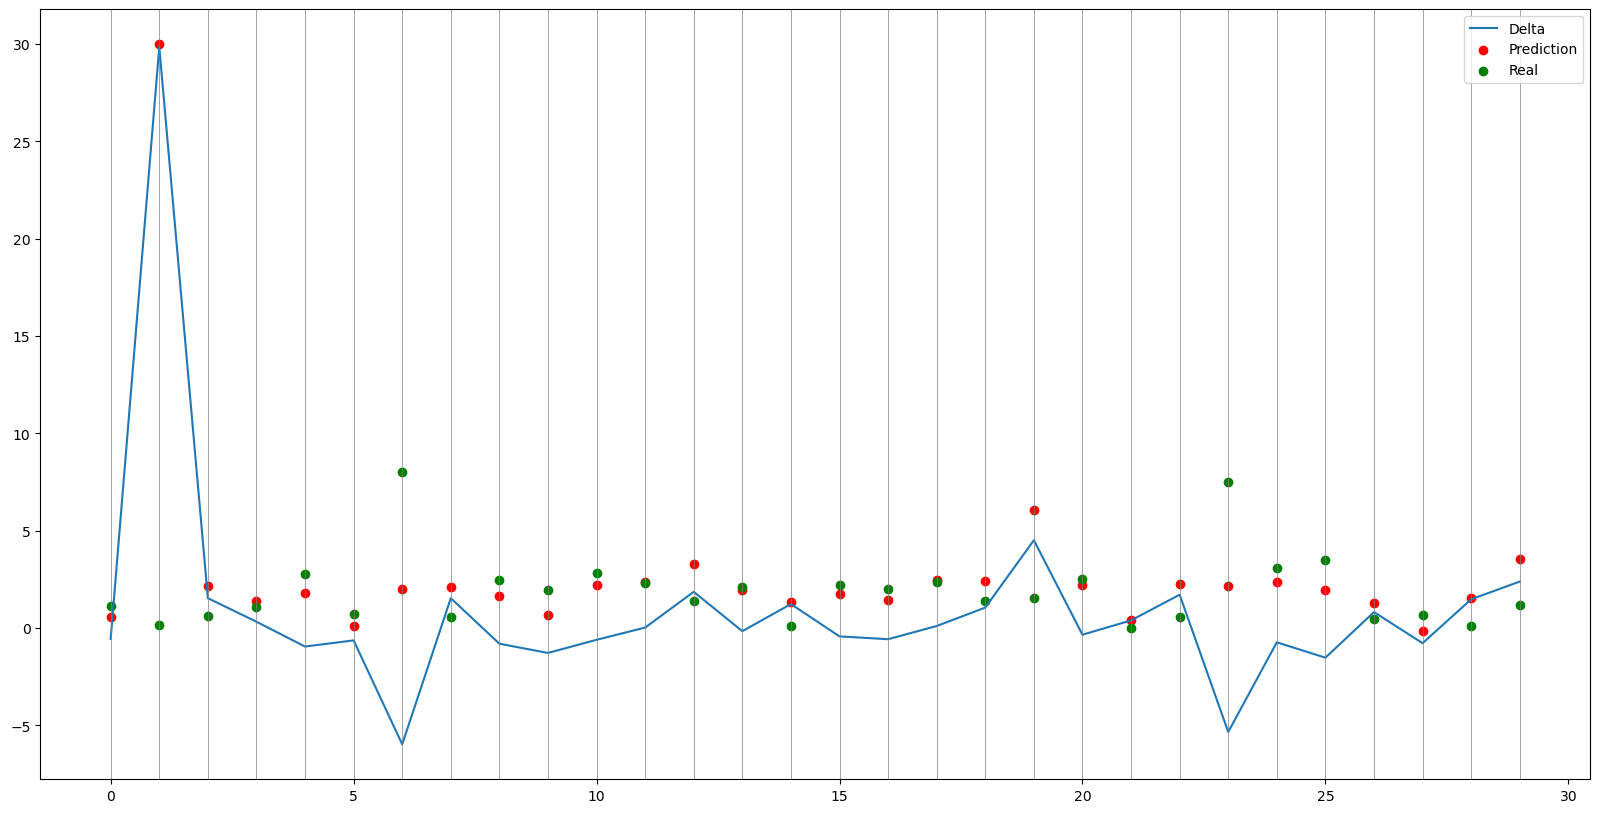

In [27]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,len(X_test)),test_predictions-y_test, label="Delta")

plt.scatter(np.arange(0,len(X_test)),test_predictions,c="r", label="Prediction")
plt.scatter(np.arange(0,len(X_test)),y_test,c="g",label="Real")

for i in range(0,len(X_test)):
    plt.axvline(i,lw=0.5,c="gray")

plt.legend()


#### ALL

In [130]:
X = fermi_rs.drop('redshift',axis=1)
y = fermi_rs['redshift']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [132]:
model = LinearRegression()
model.fit(X_train,y_train)
test_predictions = model.predict(X_test)


In [133]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [134]:
RMSE

30.28037538837311

In [135]:
RMSE

30.28037538837311

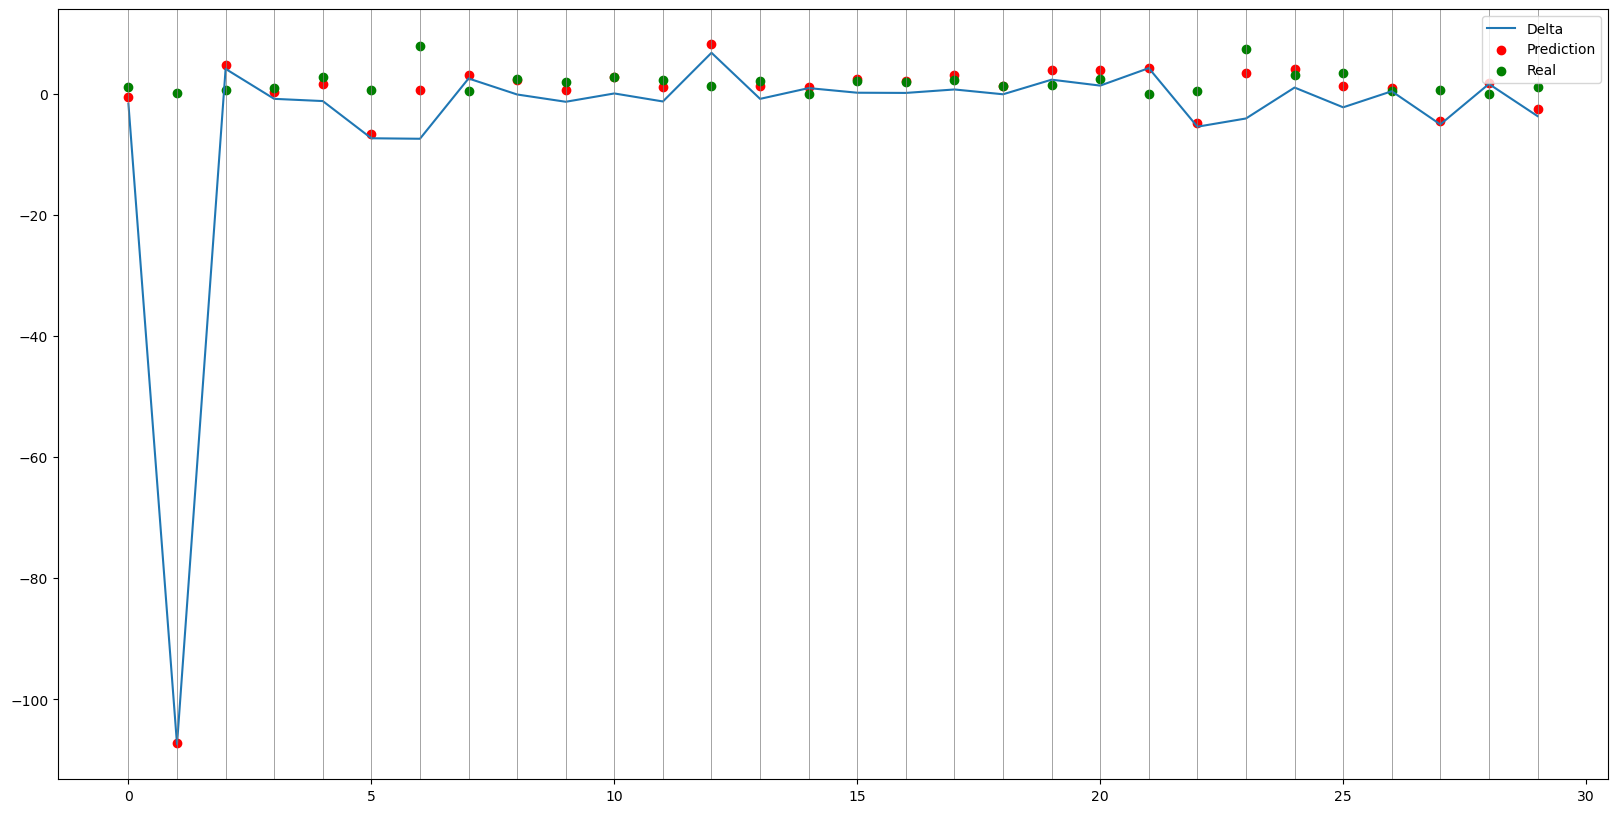

In [153]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,len(X_test)),test_predictions-y_test, label="Delta")

plt.scatter(np.arange(0,len(X_test)),test_predictions,c="r", label="Prediction")
plt.scatter(np.arange(0,len(X_test)),y_test,c="g",label="Real")

for i in range(0,len(X_test)):
    plt.axvline(i,lw=0.5,c="gray")

plt.legend()
#plt.ylim(0,30)

In [137]:
fermi_rs

,T90,FLUENCE,FLUX_1024,FLUX_1024_TIME,FLUX_64,FLNC_BAND_AMPL,FLNC_BAND_EPEAK,FLNC_BAND_ALPHA,FLNC_BAND_BETA,FLNC_SPECTRUM_START,...,FLNC_SBPL_PHTFLNC,FLNC_SBPL_ERGFLUX,FLNC_SBPL_ERGFLNC,FLNC_SBPL_PHTFLUXB,FLNC_SBPL_PHTFLNCB,FLNC_SBPL_ERGFLNCB,FLNC_SBPL_REDCHISQ,FLNC_SBPL_REDFITSTAT,FLNC_SBPL_DOF,redshift
0,18.624,2.124800e-05,36.8825,6.080,42.8077,0.032017,86.14947,-1.125799,-2.252489,-1.024,...,260.930500,6.433160e-07,2.427931e-05,1.808740,68.263420,1.150329e-05,1.230,1.959,480.0,1.20760
1,49.152,2.037100e-06,2.9311,4.480,6.7633,0.004377,112.50810,-1.703981,-20.463630,-5.120,...,23.824370,1.866903e-07,1.714404e-06,0.541614,4.973725,8.708315e-07,1.018,1.087,358.0,1.96800
2,44.033,1.942800e-04,26.7215,94.913,44.6668,0.029984,1317.51800,-0.984421,-2.796243,-1.024,...,710.519200,3.423854e-06,2.019652e-04,4.740811,279.649400,6.136464e-05,1.157,2.836,360.0,1.80375
3,0.512,3.025800e-07,3.3190,-0.256,6.5443,0.024535,195.22360,-0.726783,-9.536743,-0.256,...,1.690118,5.495920e-07,2.100202e-07,1.951229,0.745640,1.462976e-07,0.990,1.055,477.0,1.37000
4,20.736,1.625100e-05,11.3138,3.712,12.7752,0.012544,350.78980,-0.775625,-1.966854,-2.048,...,91.067820,6.963493e-07,1.988851e-05,1.455391,41.567560,8.688411e-06,1.064,1.357,482.0,0.66780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,11.776,3.258300e-06,7.7439,1.984,10.4906,0.060219,44.31059,-0.679006,-2.334998,-2.048,...,52.850890,2.686356e-07,3.837020e-06,0.747406,10.675470,1.689480e-06,1.178,1.700,481.0,1.79800
145,369.670,1.789800e-04,73.0749,16.576,83.6413,0.022010,355.19420,-1.015369,-2.231822,-15.360,...,1156.894000,1.187308e-06,2.033261e-04,2.724943,466.645700,9.435617e-05,1.234,2.781,478.0,1.17000
146,64.769,1.314600e-05,5.5737,14.144,7.4404,0.007310,277.49020,-1.015704,-2.651900,-2.048,...,124.454200,3.159167e-07,1.902344e-05,0.820565,49.411640,9.713362e-06,1.156,2.049,480.0,3.33200
147,112.386,2.684500e-04,68.7202,63.361,76.1647,0.057884,149.04040,-1.114409,-2.239346,-1.024,...,2389.220000,1.742523e-06,2.749340e-04,4.936748,778.916300,1.397150e-04,1.317,10.407,236.0,0.54000


#### FLNC

In [138]:
X = fermi_flnc.drop('redshift',axis=1)
y = fermi_flnc['redshift']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [140]:
model = LinearRegression()
model.fit(X_train,y_train)
test_predictions = model.predict(X_test)


In [141]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [142]:
RMSE

2.1679969985494862

In [143]:
RMSE

2.1679969985494862

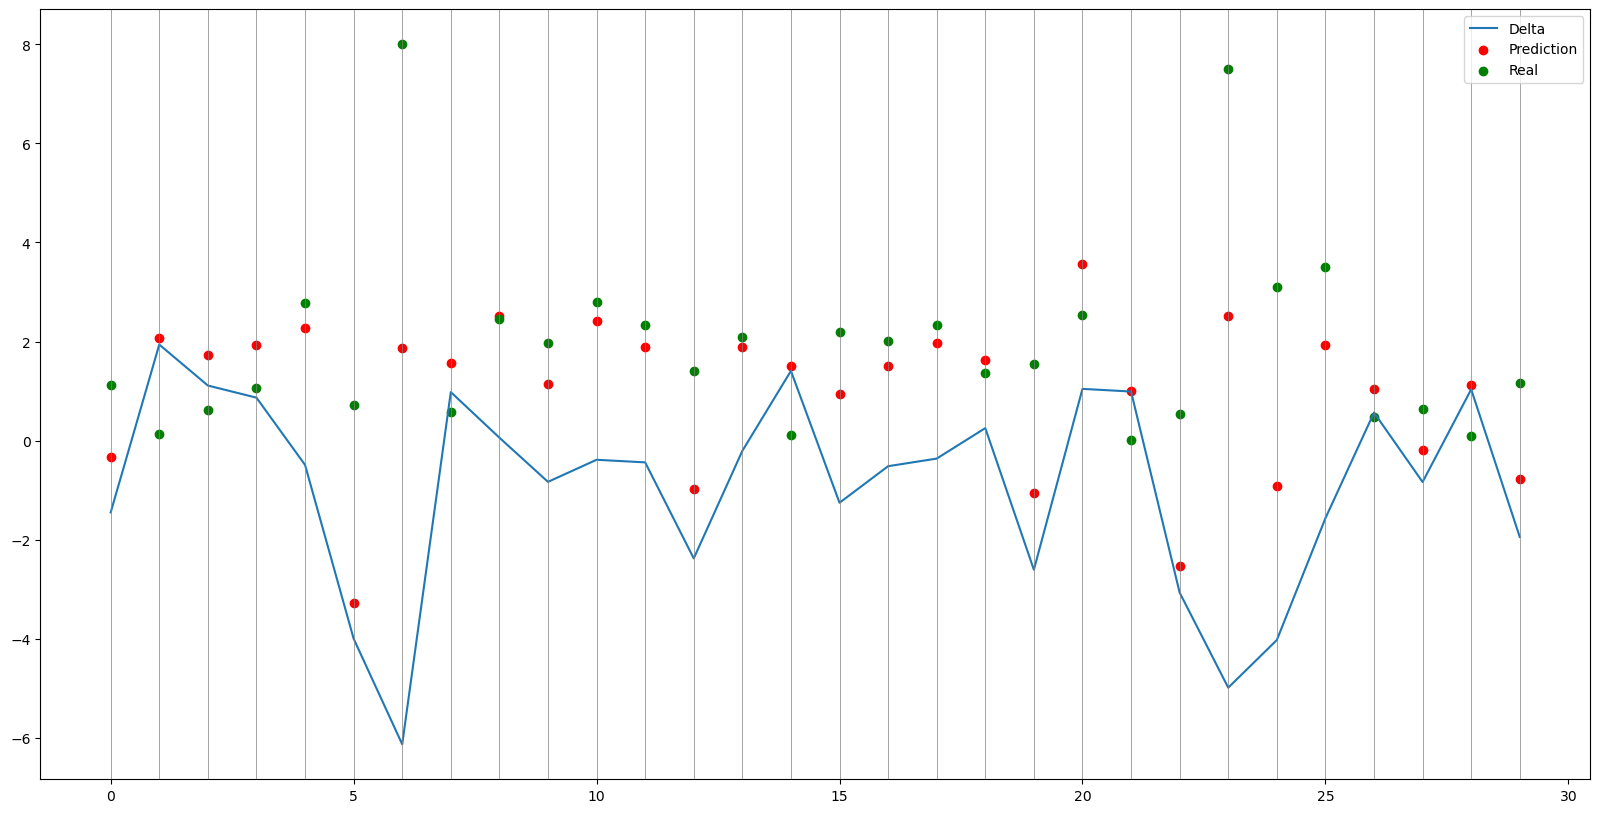

In [144]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,len(X_test)),test_predictions-y_test, label="Delta")

plt.scatter(np.arange(0,len(X_test)),test_predictions,c="r", label="Prediction")
plt.scatter(np.arange(0,len(X_test)),y_test,c="g",label="Real")

for i in range(0,len(X_test)):
    plt.axvline(i,lw=0.5,c="gray")

plt.legend()

In [145]:
fermi_rs

,T90,FLUENCE,FLUX_1024,FLUX_1024_TIME,FLUX_64,FLNC_BAND_AMPL,FLNC_BAND_EPEAK,FLNC_BAND_ALPHA,FLNC_BAND_BETA,FLNC_SPECTRUM_START,...,FLNC_SBPL_PHTFLNC,FLNC_SBPL_ERGFLUX,FLNC_SBPL_ERGFLNC,FLNC_SBPL_PHTFLUXB,FLNC_SBPL_PHTFLNCB,FLNC_SBPL_ERGFLNCB,FLNC_SBPL_REDCHISQ,FLNC_SBPL_REDFITSTAT,FLNC_SBPL_DOF,redshift
0,18.624,2.124800e-05,36.8825,6.080,42.8077,0.032017,86.14947,-1.125799,-2.252489,-1.024,...,260.930500,6.433160e-07,2.427931e-05,1.808740,68.263420,1.150329e-05,1.230,1.959,480.0,1.20760
1,49.152,2.037100e-06,2.9311,4.480,6.7633,0.004377,112.50810,-1.703981,-20.463630,-5.120,...,23.824370,1.866903e-07,1.714404e-06,0.541614,4.973725,8.708315e-07,1.018,1.087,358.0,1.96800
2,44.033,1.942800e-04,26.7215,94.913,44.6668,0.029984,1317.51800,-0.984421,-2.796243,-1.024,...,710.519200,3.423854e-06,2.019652e-04,4.740811,279.649400,6.136464e-05,1.157,2.836,360.0,1.80375
3,0.512,3.025800e-07,3.3190,-0.256,6.5443,0.024535,195.22360,-0.726783,-9.536743,-0.256,...,1.690118,5.495920e-07,2.100202e-07,1.951229,0.745640,1.462976e-07,0.990,1.055,477.0,1.37000
4,20.736,1.625100e-05,11.3138,3.712,12.7752,0.012544,350.78980,-0.775625,-1.966854,-2.048,...,91.067820,6.963493e-07,1.988851e-05,1.455391,41.567560,8.688411e-06,1.064,1.357,482.0,0.66780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,11.776,3.258300e-06,7.7439,1.984,10.4906,0.060219,44.31059,-0.679006,-2.334998,-2.048,...,52.850890,2.686356e-07,3.837020e-06,0.747406,10.675470,1.689480e-06,1.178,1.700,481.0,1.79800
145,369.670,1.789800e-04,73.0749,16.576,83.6413,0.022010,355.19420,-1.015369,-2.231822,-15.360,...,1156.894000,1.187308e-06,2.033261e-04,2.724943,466.645700,9.435617e-05,1.234,2.781,478.0,1.17000
146,64.769,1.314600e-05,5.5737,14.144,7.4404,0.007310,277.49020,-1.015704,-2.651900,-2.048,...,124.454200,3.159167e-07,1.902344e-05,0.820565,49.411640,9.713362e-06,1.156,2.049,480.0,3.33200
147,112.386,2.684500e-04,68.7202,63.361,76.1647,0.057884,149.04040,-1.114409,-2.239346,-1.024,...,2389.220000,1.742523e-06,2.749340e-04,4.936748,778.916300,1.397150e-04,1.317,10.407,236.0,0.54000


#### PFLX

In [146]:
X = fermi_pflx.drop('redshift',axis=1)
y = fermi_pflx['redshift']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [148]:
model = LinearRegression()
model.fit(X_train,y_train)
test_predictions = model.predict(X_test)


In [149]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [150]:
RMSE

19.873406806222444

In [151]:
RMSE

19.873406806222444

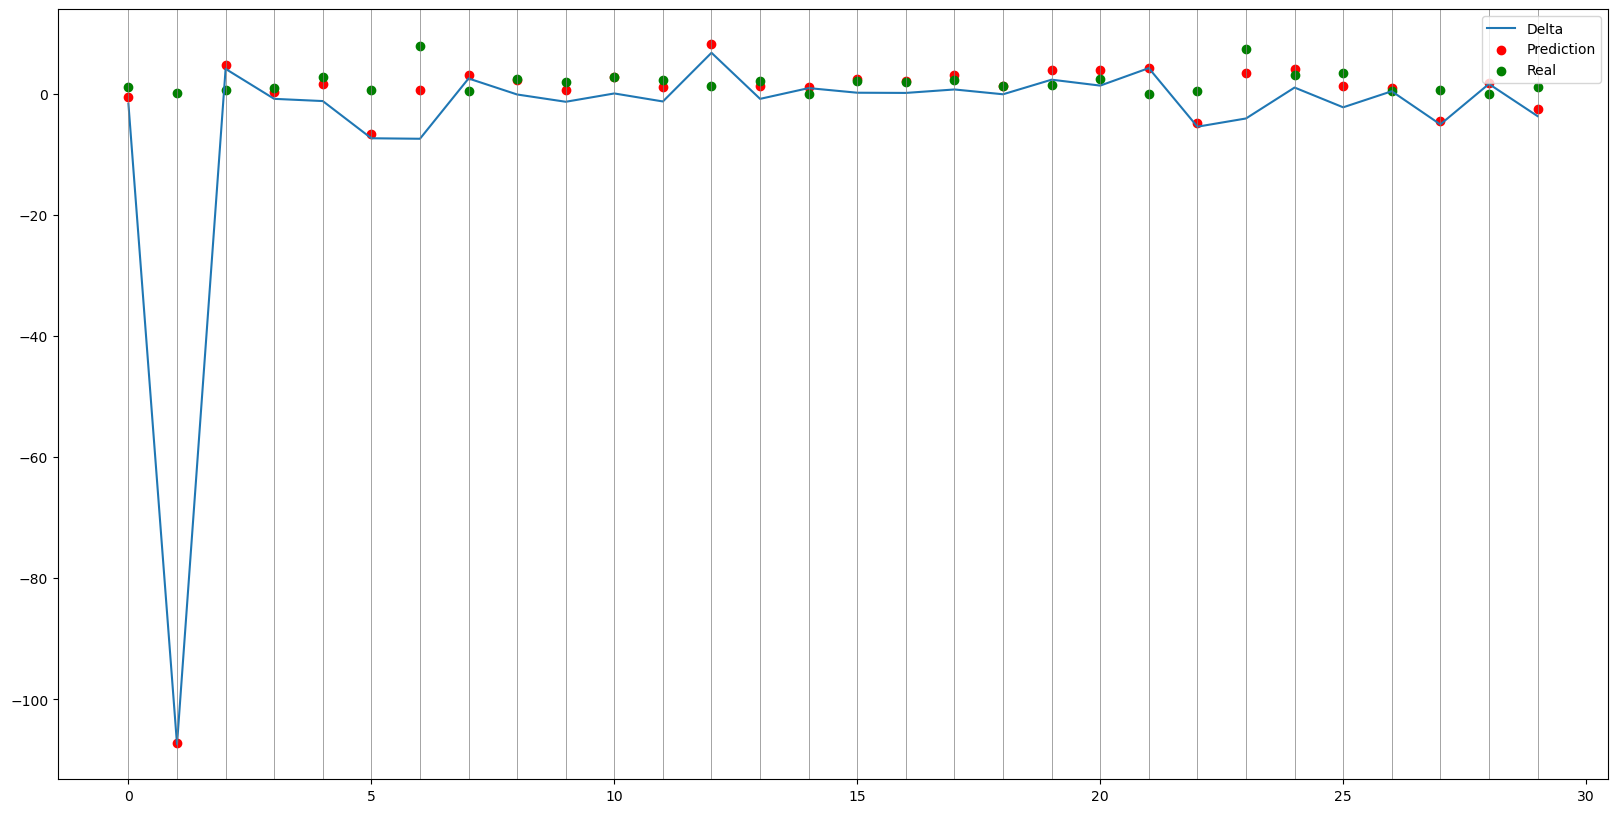

In [156]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,len(X_test)),test_predictions-y_test, label="Delta")

plt.scatter(np.arange(0,len(X_test)),test_predictions,c="r", label="Prediction")
plt.scatter(np.arange(0,len(X_test)),y_test,c="g",label="Real")

for i in range(0,len(X_test)):
    plt.axvline(i,lw=0.5,c="gray")

plt.legend()
#plt.ylim(-10,10)

#### Band Comp

In [158]:
X = fermi_band_comp.drop('redshift',axis=1)
y = fermi_band_comp['redshift']

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [160]:
model = LinearRegression()
model.fit(X_train,y_train)
test_predictions = model.predict(X_test)


In [161]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [162]:
RMSE

13.016175667479558

In [163]:
RMSE

13.016175667479558

(-10.0, 10.0)

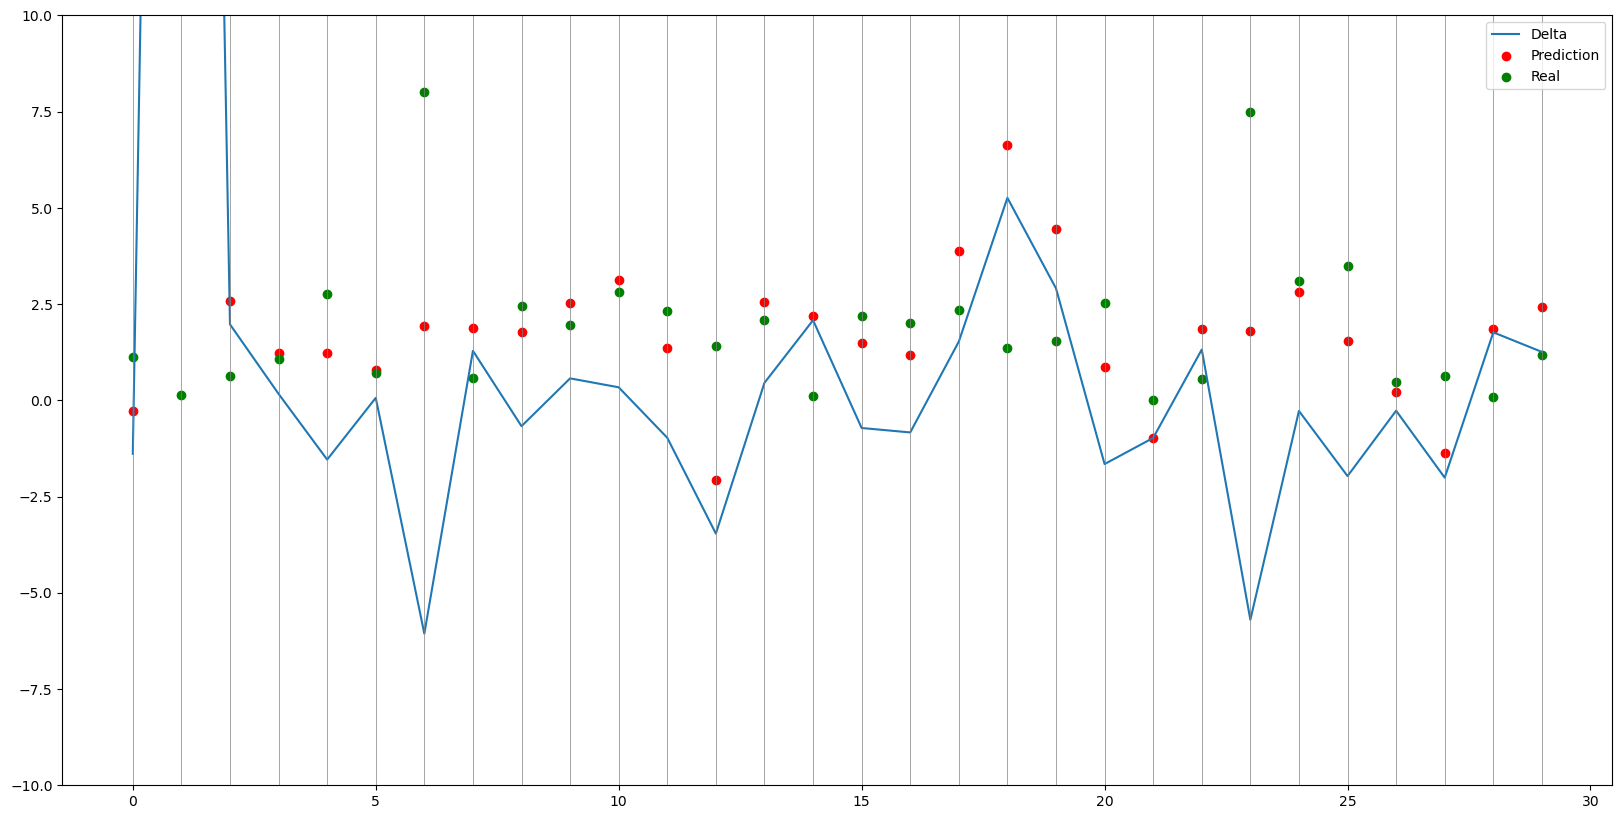

In [165]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,len(X_test)),test_predictions-y_test, label="Delta")

plt.scatter(np.arange(0,len(X_test)),test_predictions,c="r", label="Prediction")
plt.scatter(np.arange(0,len(X_test)),y_test,c="g",label="Real")

for i in range(0,len(X_test)):
    plt.axvline(i,lw=0.5,c="gray")

plt.legend()
plt.ylim(-10,10)

### 2.1.2. Lasso

### 2.1.3. Ridge

### 2.1.4. Elastic Net

## 2.2. Support Vector Machine (SVM)

## 2.3. Decision Tree

## 2.4. Random Forest

## 2.5. Boosted Trees